In [2]:
#calcular parâmetros das galáxias
#EM CONSTRUÇÃO!
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph
import scipy.ndimage as ndi

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

Filename: UM455_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (996, 2048)   float32   
Original
Nível de fundo = 0.301015
Ruído de fundo = 0.023669
Subtraido
Nível de fundo = 0.000000
Ruído de fundo = 0.023669


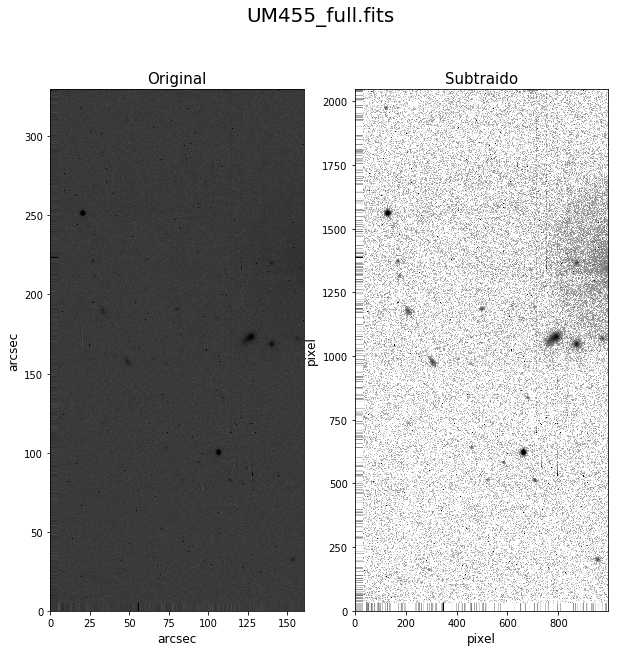

In [3]:
#Full image + backgoround + noise
from astropy.io import fits
from copy import deepcopy

#IMAGEM
filename = 'UM455'

image_full='UM455_full.fits'
#image_full = get_pkg_data_filename(image_full) #Info WCS
fits.info(image_full)

FITSe = fits.open(image_full)
FITSe = FITSe[0].data
FITS = deepcopy(FITSe)
x , y = FITSe.shape[1] , FITSe.shape[0] #limite dos eixos usado para formatar os axis image. (tbm pode ser usado FITSe[0].header[3] e 4)
#------------------------------
weight = 'map_rms.fits'   #Importe o mapa de peso. Estatística de Poisson.
MAP_RMS = fits.open(weight)
map_rms = MAP_RMS[0].data
#------------------------------
MASK = 'flag.fits'        #Importe a máscara.
Mask = fits.open(MASK)
Mask = Mask[0].data
#------------------------------
SEGMAP = 'segmentation.fits'  #Importe o mapa de segmentação. OPICIONAL se for usar sextractor
Segmap = fits.open(SEGMAP)
Segmap = Segmap[0].data
#------------------------------
from astropy.stats import sigma_clipped_stats  #Estatistica sigma clipped
mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Original')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

FITSe -= median  #subtraindo o background

mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Subtraido')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

#--------------------------
#Plot das imagens
fig ,(ax1 , ax2) = plt.subplots(1,2,figsize=(10, 10))
fig.suptitle(image_full, fontsize=20)
#import matplotlib.ticker as ticker
#ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_xlabel('arcsec',fontsize=12)
ax1.set_ylabel('arcsec',fontsize=12)
ax1.set_title('Original',fontsize=15)
ax1.imshow(FITS, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0),extent=[0,x*0.161,0,y*0.161])
ax1.set_aspect(1)

ax2.set_xlabel('pixel',fontsize=12)
ax2.set_ylabel('pixel',fontsize=12)
ax2.set_title('Subtraido',fontsize=15)
ax2.imshow(FITSe, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))


In [4]:
#Cuts image
GHII = FITS[900:1200,650:950]  # [y1:y2,x1:x2] . obs:Já está em FITS[0].data
image_star = FITS[560:680,600:720]
map_rms = map_rms[900:1200,650:950]
Mask = Mask[900:1200,650:950]
Segmap = Segmap[900:1200,650:950]

Nível de fundo = 0.308369
Ruído de fundo = 0.025204
[[ 0.01667786 -0.00958639 -0.04458141 ...  0.00927675 -0.01249099
  -0.0065473 ]
 [ 0.02905855 -0.00892502 -0.04118791 ...  0.00227439  0.00572899
   0.01700839]
 [ 0.01105362 -0.01133582  0.00404406 ...  0.00481367  0.01169905
  -0.00443065]
 ...
 [ 0.01779059  0.04774642  0.01270756 ... -0.02575421 -0.00757226
   0.03281078]
 [ 0.00612924  0.01570362  0.02792156 ... -0.01983166 -0.0113627
   0.0137479 ]
 [-0.03044432 -0.02216643  0.00948364 ...  0.02981004 -0.00758976
   0.04553401]]
300


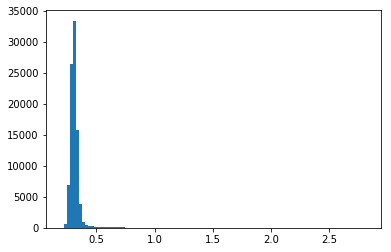

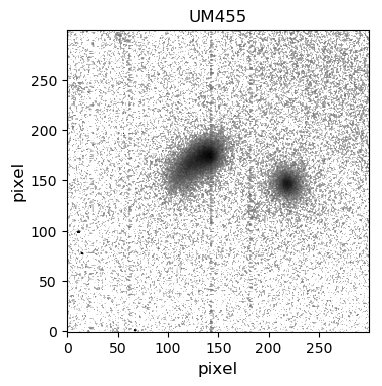

In [5]:
#Galáxia
image_data = GHII
NBINS = 100
histogram = plt.hist(image_data.flatten(), NBINS) #histograma usado para saber os limites de pixel

mean , median , std = sigma_clipped_stats( image_data, sigma = 3. )
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))
image_data-=median

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)

print(image_data)
print(len(image_data))
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
#plt.savefig(GHII+'_ori.png')

#image_data.writeto( 'new_'+filename+'.fits',overwrite='true',checksum='true' ) #Cria um fits novo 

[[ 2.4802983e-03 -4.5116842e-03 -3.7573546e-02 ...  2.8020561e-02
  -1.3177991e-03  1.3152033e-02]
 [-3.1248629e-03 -9.9438727e-03  1.4579594e-02 ...  3.6751390e-02
   1.8973827e-02 -4.7008902e-02]
 [ 9.1693103e-03  7.0814490e-03  8.3249807e-04 ...  3.0059338e-02
  -8.1272721e-03 -1.8576413e-02]
 ...
 [ 1.8562108e-02  1.3920605e-02  1.3785511e-02 ...  3.1888485e-05
   5.3036213e-04  1.9497722e-02]
 [-9.2819631e-03 -2.0301044e-03 -7.8577995e-03 ...  8.8458657e-03
   2.9308796e-03 -1.8479049e-02]
 [ 7.5524747e-03 -1.6441435e-02  1.0305136e-02 ... -8.6900592e-04
  -8.9842081e-03 -3.4455955e-02]]
120


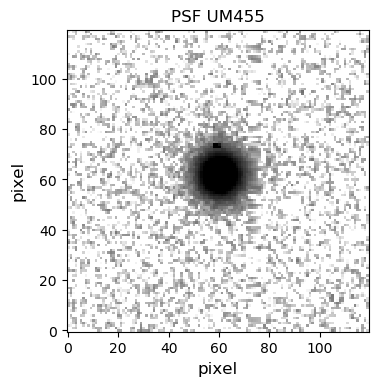

In [6]:
#Estrela PSF
psf = image_star

#median = np.median(psf)
mean , median , std = sigma_clipped_stats( psf , sigma = 3. ) 
psf -= median
fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title('PSF '+filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(psf, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
print(psf) #Matriz estrela
print(len(psf))

[[0.02248934 0.02250182 0.02251375 ... 0.02253213 0.02252984 0.02252783]
 [0.02250377 0.02251652 0.02252867 ... 0.02253512 0.02253288 0.02253089]
 [0.02251797 0.02253098 0.02254335 ... 0.02253811 0.02253591 0.02253396]
 ...
 [0.02276752 0.02277352 0.02277934 ... 0.02388613 0.02389656 0.02390868]
 [0.02277047 0.02277671 0.02278274 ... 0.02388152 0.02389185 0.02390388]
 [0.0227738  0.0227803  0.02278655 ... 0.02387754 0.02388777 0.02389971]]
300


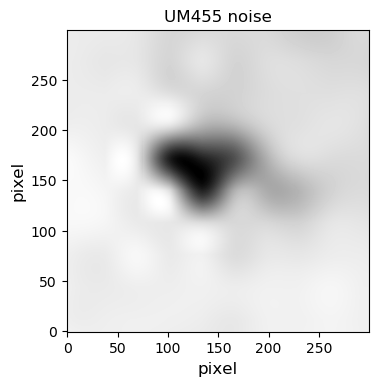

In [7]:
#mapa RMS - weight maps

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' noise')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(map_rms, origin='lower', cmap='gray_r')
print(map_rms) #Matriz mapa de pixel da galáxia
print(len(map_rms))
#plt.savefig(GHII+'_object.png')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


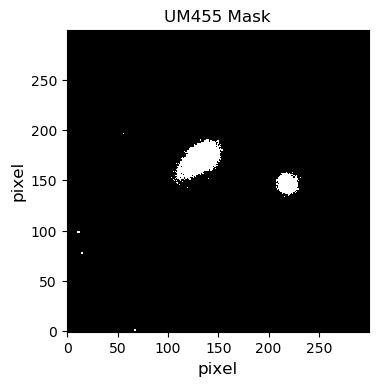

In [8]:
#Fase de TESTE - FLAG derivado do WW, como mask 
#Imagem mask. Estou usando uma matriz 2D 0 e 1
#A mascara é uma matriz booleana que determina os pixels a serem desconsiderados. True é desconsiderado.

Mask = Mask >= 1  #transforma em matriz booleana

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' Mask')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(Mask, origin='lower',  cmap='gray')
print(Mask)
#plt.savefig(GHII+'_mask.png')

In [9]:
#Segmentação derivada do SEXTRACTOR
segmap = Segmap
segmap = segmap_float > 0.9

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' segmatation')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(segmap, origin='lower', cmap='gray')
print(segmap)

NameError: name 'segmap_float' is not defined

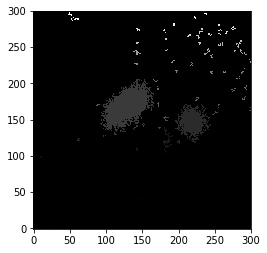

In [10]:
# Segmentação derivada da tarefa PHOTOTUTILS
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
threshold = photutils.detect_threshold(image_data, snr=1.5)
npixels = 8  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)
plt.imshow(segm, origin='lower', cmap='gray')

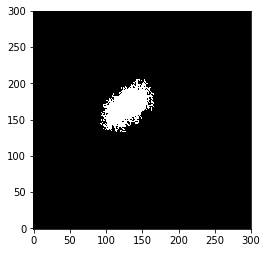

In [11]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

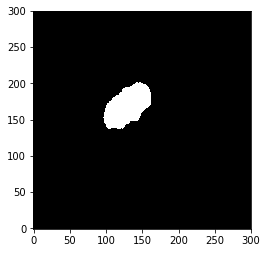

In [12]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

#plt.savefig(GHII+'_segment.png')

In [13]:
#Se tiver fontes sobrepostas usar
#objeto.deblend_sources() #para alterar as fontes.

In [14]:
#Agora que temos todos os dados necessários
#Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
#Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time() #Tempo total do processo
source_morphs = statmorph.source_morphology(image_data, segmap, weightmap=map_rms, psf=psf, niter_bh_mid=100, eta=0.2)
print('Time: %g s.' % (time.time() - start))

Finished processing source 1.

Time: 2.90519 s.


In [15]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('Asymmetry as described in Lotz et al. (2004) =',morph.asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A , asymmetry as described in Lotz et al. (2004) =', morph.asymmetry)
print('S , smoothness as described in Conselice (2003) =', morph.smoothness)
print('Shape asymmetry as described in Pawlik et al. (2016) =', morph.shape_asymmetry)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean, mean background value =', morph.sky_mean)
print('sky_median, median background =', morph.sky_median)
print('sky_sigma, std devia. background =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcseg =',morph.r50*0.161)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz em arcseg =',morph.rhalf_ellip*0.161)
print('Fluxpetro_c, Return the sum of the pixel values over a circle aperture = ',morph.flux_circ)
print('Fluxpetro_e, Return the sum of the pixel values over a elliptical aperture =',morph.flux_ellip)
print('Intensity statistic as described in Peth et al. (2016) =',morph.intensity)
print('Desviation statistic as described in Peth et al. (2016) =',morph.deviation) 
print('Multimode statistic as described in Freeman et al. (2013) =',morph.multimode)

xc_centroid = 131.32293434788303
yc_centroid = 170.51951446440566
ellipticity_centroid = 0.46541709308118473
elongation_centroid = 1.8706172364614448
orientation_centroid = 0.6803618709646282
xc_asymmetry = 131.7732748501112
yc_asymmetry = 171.70477974237133
ellipticity_asymmetry = 0.4651737606311994
elongation_asymmetry = 1.869766152797954
orientation_asymmetry = 0.6845923715813408
Asymmetry as described in Lotz et al. (2004) = 0.16584048573355947
rpetro_circ = 34.73248102248805
rpetro_ellip = 43.66715670511392
rhalf_circ = 15.030460631415602
rhalf_ellip = 19.77236400260459
r20 = 8.321074925869008
r50 = 15.03166279569991
r80 = 26.777114054557906
Gini = 0.5094768505786501
M20 = -1.2507835560704463
F(G, M20) = -0.5712965852788625
S(G, M20) = 0.0035231677790715232
sn_per_pixel = 4.8525033
C = 2.537921679312655
A , asymmetry as described in Lotz et al. (2004) = 0.16584048573355947
S , smoothness as described in Conselice (2003) = 0.0026449904168325735
Shape asymmetry as described in Pawli

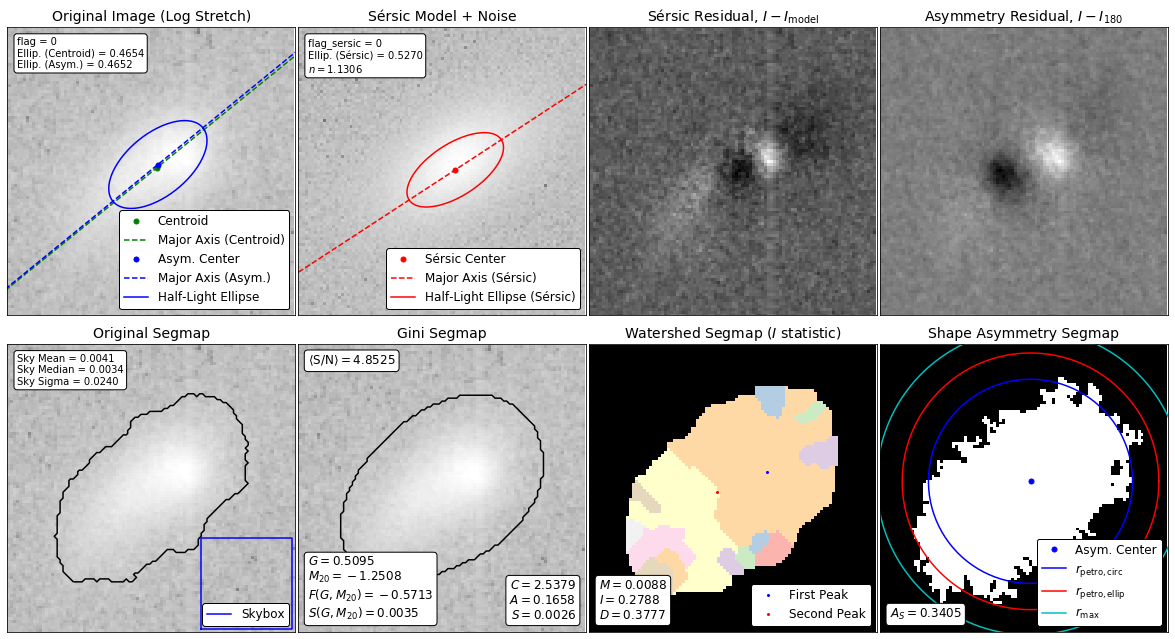

In [84]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig('/home/JackS/Documentos/python/imagens/'+filename+'_morph.png', dpi=150)

In [102]:
#Tabela de saída csv
from datetime import date
import pandas as pd
date_op = date.today()
date_format = date_op.strftime('%d/%m/%Y')

sky_background = morph.sky_sigma
SMA50 = morph.rhalf_ellip
ellip = morph.ellipticity_asymmetry
R50p = morph.r50*0.161
Rpetro_e = morph.rpetro_ellip*0.161
fluxpetro_e = morph.flux_ellip

try:
    tabout = pd.read_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",encoding = 'UTF-8',sep=";")
    tabout.loc[len(CSV)] = [filename,SMA50,ellip,Rpetro_e,R50p,fluxpetro_e,sky_background,date_format]
    tabout.to_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")
except FileNotFoundError:
    tabout = pd.DataFrame({'Galaxy':[filename],'SMA_50 (px)':[SMA50],'e':[ellip],'Rpetro (arcsec)':[Rpetro_e],
                       'R_50 (arcsec)':[R50p],'Fluxpetro':[fluxpetro_e],'std_dev_Background':[sky_background],
                      'Date: ':[date_format]},columns = ['Galaxy','SMA_50 (px)','e','Rpetro (arcsec)',
                                                         'R_50 (arcsec)','Fluxpetro','std_dev_Background',
                                                         'Date'])
    tabout.to_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")

coment = ' '


In [103]:
CSV = pd.read_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",encoding = 'UTF-8',sep=";")

In [104]:
CSV.head()

,Galaxy,SMA_50 (px),e,Rpetro (arcsec),R_50 (arcsec),Fluxpetro,std_dev_Background,Date
0,UM455,19.772364,0.465174,7.030412,2.420098,565.508101,0.023981,NaN
1,UM455,19.772364,0.465174,7.030412,2.420098,565.508101,0.023981,19/04/2020


In [105]:
tabout.loc[0]

Galaxy                    UM455
SMA_50 (px)             19.7724
e                      0.465174
Rpetro (arcsec)         7.03041
R_50 (arcsec)            2.4201
Fluxpetro               565.508
std_dev_Background    0.0239812
Date                        NaN
Name: 0, dtype: object